In [1]:
import torch
from Loader_17 import DAVIS_Rawset, DAVIS_Infer, DAVIS_Dataset, normalize
from polygon import RasLoss
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
train_rawset = DAVIS_Rawset(is_train=True)
val_rawset = DAVIS_Rawset(is_train=False)

torch.Size([3, 224, 224]) torch.Size([224, 224])


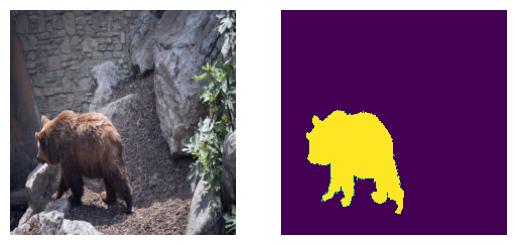

In [19]:
video_idx = 0
frame_idx = 0
bear_img, bear_mask = train_rawset.data_set[video_idx][frame_idx]
print(bear_img.shape, bear_mask.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalize(bear_img.permute(1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(bear_mask)
plt.show()

In [129]:
bear_img.shape, bear_img.new_zeros((1, ))

(torch.Size([3, 224, 224]), tensor([0.]))

torch.Size([3, 224, 224]) torch.Size([224, 224])


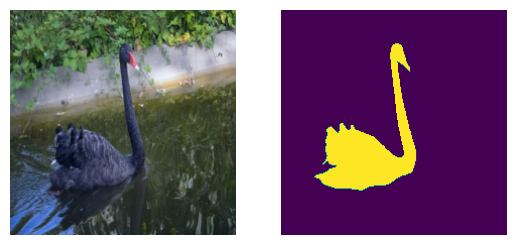

In [191]:
video_idx = 2
frame_idx = 0
swan_img, swan_mask = val_rawset.data_set[video_idx][frame_idx]
print(swan_img.shape, swan_mask.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalize(swan_img.permute(1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(swan_mask)
plt.show()

torch.Size([3, 224, 224]) torch.Size([224, 224])


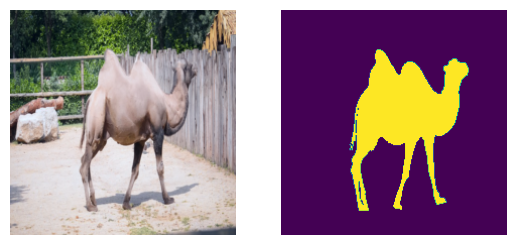

In [213]:
video_idx = 6
frame_idx = 0
camel_img, camel_mask = val_rawset.data_set[video_idx][frame_idx]
print(camel_img.shape, camel_mask.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalize(camel_img.permute(1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(camel_mask)
plt.show()

torch.Size([3, 224, 224]) torch.Size([224, 224])


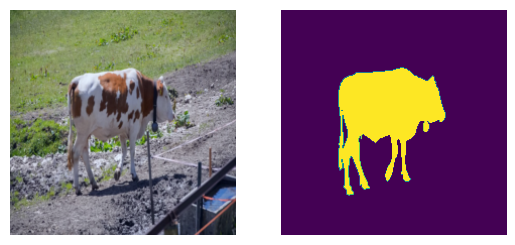

In [16]:
video_idx = 9
frame_idx = 0
cow_img, cow_mask = val_rawset.data_set[video_idx][frame_idx]
print(cow_img.shape, cow_mask.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalize(cow_img.permute(1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(cow_mask)
plt.show()

torch.Size([3, 224, 224]) torch.Size([224, 224])


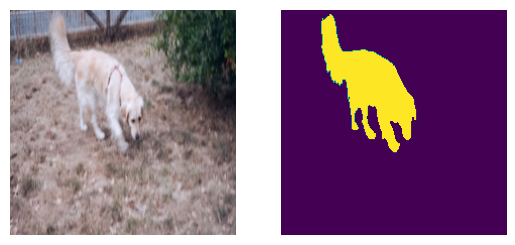

In [17]:
video_idx = 11
frame_idx = 0
dog_img, dog_mask = val_rawset.data_set[video_idx][frame_idx]
print(dog_img.shape, dog_mask.shape)
plt.figure()
plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(normalize(dog_img.permute(1, 2, 0)))
plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(dog_mask)
plt.show()

In [25]:
def get_bou_feats(img_feats: torch.Tensor, boundary: torch.Tensor) -> torch.Tensor:
    return img_feats[
        torch.arange(boundary.shape[0]).unsqueeze(1),
        :,
        boundary[:, :, 1],
        boundary[:, :, 0],
    ]

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim: int, dropout=0.1, max_seq_len=1024) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, embed_dim)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embed_dim, 2).float() * (-np.log(10000.0) / embed_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)


def get_img_tokens(img_features: torch.Tensor) -> torch.Tensor:
    img_tokens = rearrange(
        img_features,
        "b c h w -> b (h w) c",
    )
    return img_tokens

def get_extrame_4_points(batch_indices: torch.Tensor):
    if batch_indices.shape[0] == 0:
        mid = 224 // 2
        return torch.tensor([[mid, mid], [mid, mid], [mid, mid], [mid, mid]])
    x_min = batch_indices[:, 1].min()
    x_max = batch_indices[:, 1].max()
    y_min = batch_indices[:, 0].min()
    y_max = batch_indices[:, 0].max()
    return torch.tensor([[x_min, y_min], [x_min, y_max], [x_max, y_max], [x_max, y_min]])

def get_bounding_box(sgm: torch.Tensor):
    indices = torch.nonzero(sgm)
    batch_size = sgm.shape[0]
    bounding_boxes = []
    for i in range(batch_size):
        batch_indices = indices[indices[:, 0] == i][:, 1:]
        bounding_boxes.append(get_extrame_4_points(batch_indices))
    return torch.stack(bounding_boxes)

def add_mid_points(points: torch.Tensor) -> torch.Tensor:
    points_shift = torch.roll(points, 1, 1)
    mid_points = (points + points_shift) / 2
    new_points = torch.zeros((points.shape[0], points.shape[1] * 2, 2)).to(points.device)
    new_points[:, ::2] = mid_points
    new_points[:, 1::2] = points
    return new_points

In [27]:
class ImageIterBase(nn.Module):
    def __init__(
        self,
        up_transform_num=4,
        layer_num=1,
        head_num=1,
        offset_limit=56,
        freeze_backbone=True,
    ) -> None:
        super(ImageIterBase, self).__init__()
        self.offset_limit = offset_limit
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        )
        self.img_encoder = self.featup.model
        # freeze backbone
        if freeze_backbone:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_img = 384
        d_token = d_img + 2
        self.img_token_fc = nn.Linear(d_img, d_token)
        self.layer_norm = nn.LayerNorm(d_token)
        self.pos_enc = PositionalEncoding(d_token)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=head_num,
            batch_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=layer_num,
        )
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_token,
            nhead=head_num,
            batch_first=True,
        )
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=layer_num,
        )
        self.xy_offset_fc = nn.Linear(d_token, 2)
        self.up_transform_num = up_transform_num
        self.up_decoders = nn.ModuleList(
            [
                nn.TransformerDecoder(
                    decoder_layer,
                    num_layers=layer_num,
                )
                for _ in range(self.up_transform_num)
            ]
        )

    def forward(
        self,
        img: torch.Tensor,
        mask: torch.Tensor,
    ) -> torch.Tensor:
        img_feats = self.img_encoder(img)
        img_tokens = get_img_tokens(img_feats)
        img_tokens = self.img_token_fc(img_tokens)
        img_tokens = self.layer_norm(img_tokens)
        img_tokens = self.pos_enc(img_tokens)
        img_tokens = self.transformer_encoder(img_tokens)

        init_bou = get_bounding_box(mask).cuda()
        img_featup = self.featup(img)
        bou_feat = get_bou_feats(img_featup, init_bou)
        bou_tokens = torch.cat(
            [bou_feat, init_bou.float()],
            dim=-1,
        )
        bou_tokens = self.layer_norm(bou_tokens)
        bou_tokens = self.pos_enc(bou_tokens)
        bou_tokens = self.transformer_decoder(bou_tokens, img_tokens)
        xy_offset = self.xy_offset_fc(bou_tokens).sigmoid() * self.offset_limit
        init_result = init_bou + xy_offset
        init_result = init_result.clamp(0, 223)
        results = [init_result]
        for i in range(self.up_transform_num):
            up_bou = add_mid_points(results[-1])
            up_bou_feat = get_bou_feats(img_featup, up_bou.int())
            up_bou_tokens = torch.cat(
                [up_bou_feat, up_bou.float()],
                dim=-1,
            )
            up_bou_tokens = self.layer_norm(up_bou_tokens)
            up_bou_tokens = self.pos_enc(up_bou_tokens)
            up_bou_tokens = self.up_decoders[i](up_bou_tokens, img_tokens)
            xy_offset = self.xy_offset_fc(up_bou_tokens).sigmoid() * self.offset_limit
            up_result = up_bou + xy_offset
            up_result = up_result.clamp(0, 223)
            results.append(up_result)
        if self.training:
            return results
        else:
            return results[-1]

In [31]:
model = ImageIterBase().cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [126]:
type(model.featup)

hubconf.py.UpsampledBackbone

In [71]:
batch_bear_img = bear_img.unsqueeze(0).cuda()
batch_bear_mask = bear_mask.unsqueeze(0).cuda()
pred_boundary = model(batch_bear_img, batch_bear_mask)
print(pred_boundary[0])

tensor([[[ 48.1154, 123.9375],
         [ 50.2237, 223.0000],
         [141.4130, 223.0000],
         [141.5318, 133.0123]]], device='cuda:0', grad_fn=<ClampBackward1>)


In [83]:
def get_bou_iou(
    index: int,
    boundary: torch.Tensor,
    mask: torch.Tensor,
    rasterizer,
) -> torch.Tensor:
    pred_sgm = rasterizer(boundary, 224, 224)
    pred_sgm = pred_sgm[index]
    boundary = boundary[index]
    mask = mask[index]
    intersection = pred_sgm * mask
    intersection = intersection.sum()
    union = pred_sgm.sum() + mask.sum() - intersection.sum()
    iou = intersection / union
    return iou
get_bou_iou(0, pred_boundary[1], batch_bear_mask, ras_loss.soft_polygon)


tensor(2.1612e-07, device='cuda:0', grad_fn=<DivBackward0>)

In [149]:
# overfitting bear image
model = ImageIterBase(layer_num=1).cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [150]:
loss_dict = {}
iou_dict = {}
epoch_num = 300

In [151]:
for e in range(epoch_num):
    model.train()
    optimizer.zero_grad()
    pred_boundary = model(batch_bear_img, batch_bear_mask)
    loss = 0
    for i in range(len(pred_boundary)):
        loss += ras_loss(pred_boundary[i], batch_bear_mask)
    loss /= len(pred_boundary)
    loss.backward()
    optimizer.step()
    loss_dict[e] = loss.item()
    iou = get_bou_iou(0, pred_boundary[-1], batch_bear_mask, ras_loss.soft_polygon)
    iou_dict[e] = iou.item()
    print(f"Epoch {e}, Loss: {loss.item()}, IoU: {iou.item()}")

Epoch 0, Loss: 0.8486703038215637, IoU: 0.0
Epoch 1, Loss: 0.702943742275238, IoU: 0.0
Epoch 2, Loss: 0.5383661985397339, IoU: 0.050378866493701935
Epoch 3, Loss: 0.4012767970561981, IoU: 0.17619918286800385
Epoch 4, Loss: 0.31152012944221497, IoU: 0.3612191677093506
Epoch 5, Loss: 0.2713858187198639, IoU: 0.47237300872802734
Epoch 6, Loss: 0.25031766295433044, IoU: 0.5616014003753662
Epoch 7, Loss: 0.24406471848487854, IoU: 0.5912597179412842
Epoch 8, Loss: 0.24018967151641846, IoU: 0.6066113710403442
Epoch 9, Loss: 0.2389376163482666, IoU: 0.6123670339584351
Epoch 10, Loss: 0.23913612961769104, IoU: 0.6134752035140991
Epoch 11, Loss: 0.2387506067752838, IoU: 0.6143562197685242
Epoch 12, Loss: 0.2381964772939682, IoU: 0.6136878132820129
Epoch 13, Loss: 0.23813994228839874, IoU: 0.6147341132164001
Epoch 14, Loss: 0.23862695693969727, IoU: 0.6147512197494507
Epoch 15, Loss: 0.2382103055715561, IoU: 0.615163266658783
Epoch 16, Loss: 0.2384301871061325, IoU: 0.6154602766036987
Epoch 17, L

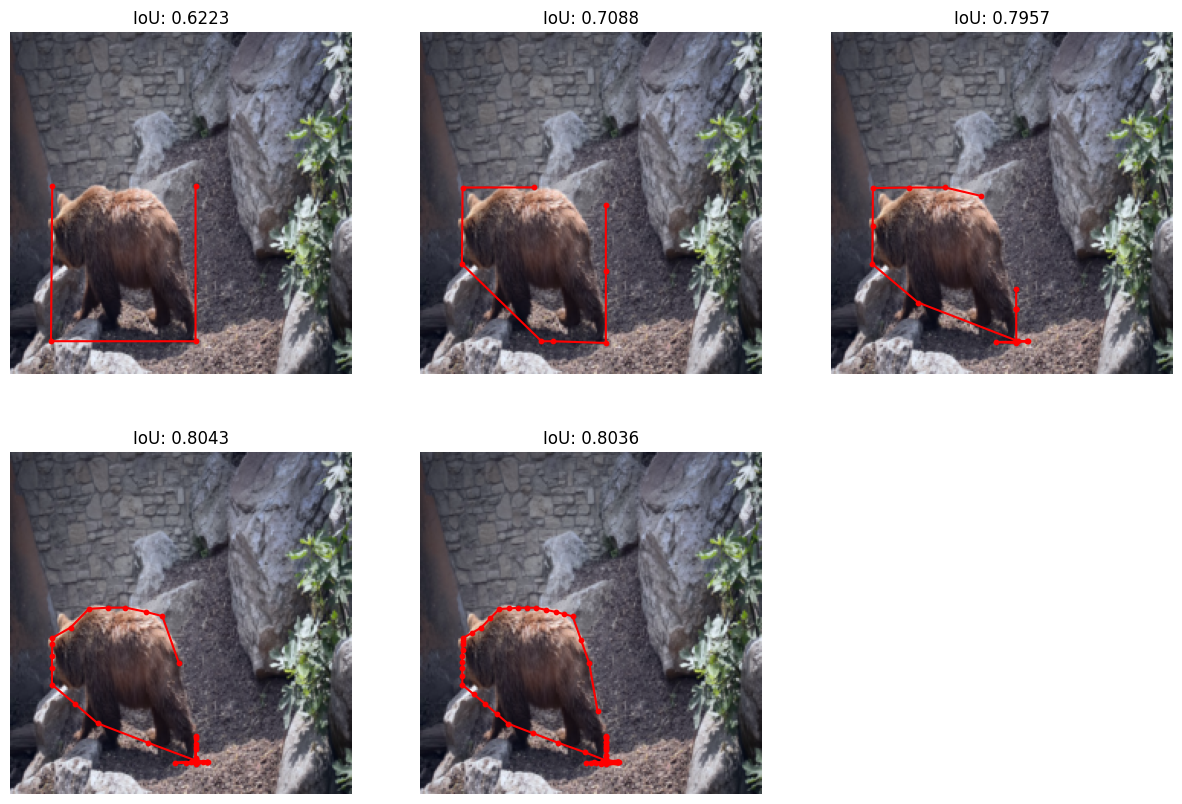

In [152]:
def show_one_image_result(
    img: torch.Tensor,
    mask: torch.Tensor,
    results: torch.Tensor,
    rasterizer: nn.Module,
    index=0,
    one_line_object_num=3,
    figure_size=(15, 10),
) -> None:
    plt.figure(figsize=figure_size)
    line_num = len(results) // one_line_object_num + 1
    for i in range(len(results)):
        plt.subplot(line_num, one_line_object_num, i + 1)
        plt.axis("off")
        iou = get_bou_iou(index, results[i], mask, rasterizer)
        plt.title(f"IoU: {iou.item():.4f}")
        plt.imshow(normalize(img[index].cpu().permute(1, 2, 0)))
        plt.scatter(results[i][index][:, 0].cpu().detach().numpy(), results[i][index][:, 1].cpu().detach().numpy(), s=10, c="r")
        plt.plot(results[i][index][:, 0].cpu().detach().numpy(), results[i][index][:, 1].cpu().detach().numpy(), c="r")
    plt.show()
pred_boundary = model(batch_bear_img, batch_bear_mask)
show_one_image_result(batch_bear_img, batch_bear_mask, pred_boundary, ras_loss.soft_polygon)

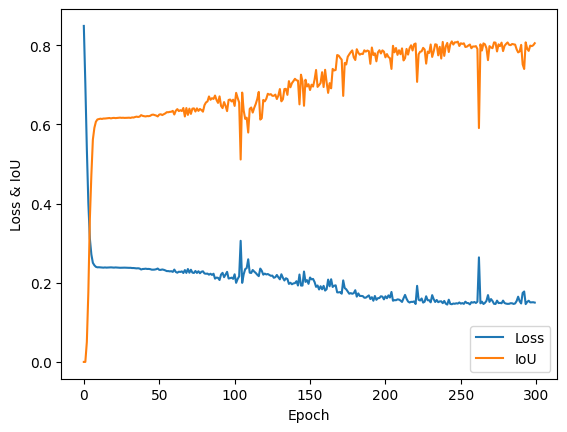

In [153]:
# show iou and loss
plt.figure()
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()


In [155]:
from MyLoss import deviation_loss, total_len_loss

In [201]:
model = ImageIterBase(layer_num=1).cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [202]:
dif_loss_dict = {}
len_loss_dict = {}
std_loss_dict = {}
iou_dict = {}
epoch_num = 300
dif_weight = 0.33
len_weight = 0.33
std_weight = 0.33

In [203]:
for e in range(epoch_num):
    model.train()
    optimizer.zero_grad()
    pred_boundary = model(batch_bear_img, batch_bear_mask)
    dif_loss = 0
    len_loss = 0
    std_loss = 0
    for i in range(len(pred_boundary)):
        dif_loss += ras_loss(pred_boundary[i], batch_bear_mask)
        len_loss += total_len_loss(pred_boundary[i])
        tmp_std_loss = deviation_loss(pred_boundary[i])
        if tmp_std_loss > 0.001:
            std_loss += tmp_std_loss
        else:
            std_loss += 0
    dif_loss /= len(pred_boundary)
    len_loss /= len(pred_boundary)
    std_loss /= len(pred_boundary)
    loss = dif_weight * dif_loss + len_weight * len_loss + std_weight * std_loss
    loss.backward()
    optimizer.step()
    iou = get_bou_iou(0, pred_boundary[-1], batch_bear_mask, ras_loss.soft_polygon)
    iou_dict[e] = iou.item()
    dif_loss_dict[e] = dif_loss.item()
    len_loss_dict[e] = len_loss.item()
    std_loss_dict[e] = std_loss.item() if std_loss != 0 else 0
    print(f"EPOCH {e}, Dif Loss: {dif_loss.item():.4f}, Len Loss: {len_loss.item():.4f}, Std Loss: {std_loss_dict[e]:.4f}, IoU: {iou.item():.4f}")

EPOCH 0, Dif Loss: 0.9088, Len Loss: 0.1319, Std Loss: 0.0290, IoU: 0.0000
EPOCH 1, Dif Loss: 0.8390, Len Loss: 0.1445, Std Loss: 0.0294, IoU: 0.0000
EPOCH 2, Dif Loss: 0.7549, Len Loss: 0.1520, Std Loss: 0.0215, IoU: 0.0000
EPOCH 3, Dif Loss: 0.6717, Len Loss: 0.1606, Std Loss: 0.0205, IoU: 0.0000
EPOCH 4, Dif Loss: 0.5771, Len Loss: 0.1659, Std Loss: 0.0166, IoU: 0.0000
EPOCH 5, Dif Loss: 0.5185, Len Loss: 0.1700, Std Loss: 0.0135, IoU: 0.0037
EPOCH 6, Dif Loss: 0.4629, Len Loss: 0.1690, Std Loss: 0.0135, IoU: 0.0249
EPOCH 7, Dif Loss: 0.4139, Len Loss: 0.1701, Std Loss: 0.0117, IoU: 0.0721
EPOCH 8, Dif Loss: 0.3617, Len Loss: 0.1710, Std Loss: 0.0095, IoU: 0.1704
EPOCH 9, Dif Loss: 0.3130, Len Loss: 0.1712, Std Loss: 0.0089, IoU: 0.2823
EPOCH 10, Dif Loss: 0.2796, Len Loss: 0.1715, Std Loss: 0.0079, IoU: 0.4024
EPOCH 11, Dif Loss: 0.2582, Len Loss: 0.1712, Std Loss: 0.0069, IoU: 0.5042
EPOCH 12, Dif Loss: 0.2465, Len Loss: 0.1711, Std Loss: 0.0061, IoU: 0.5657
EPOCH 13, Dif Loss: 0.

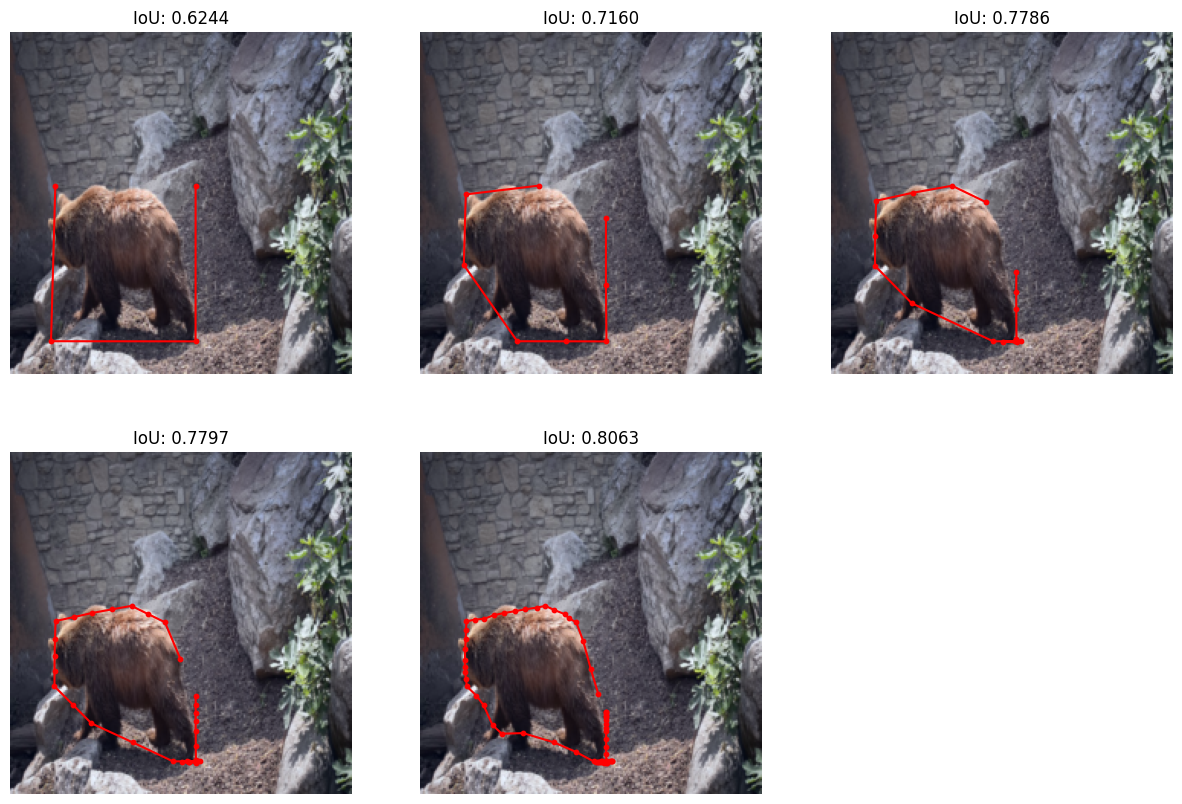

In [187]:
pred_boundary = model(batch_bear_img, batch_bear_mask)
show_one_image_result(batch_bear_img, batch_bear_mask, pred_boundary, ras_loss.soft_polygon)

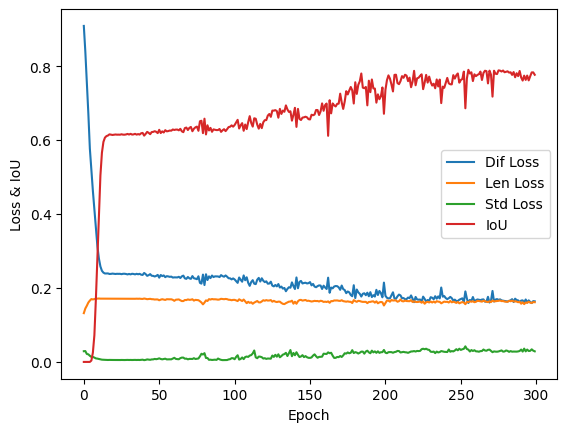

In [204]:
# show iou and loss
plt.figure()
plt.plot(list(dif_loss_dict.keys()), list(dif_loss_dict.values()), label="Dif Loss")
plt.plot(list(len_loss_dict.keys()), list(len_loss_dict.values()), label="Len Loss")
plt.plot(list(std_loss_dict.keys()), list(std_loss_dict.values()), label="Std Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()

In [192]:
# overfitting swan image
batch_swan_img = swan_img.unsqueeze(0).cuda()
batch_swan_mask = swan_mask.unsqueeze(0).cuda()
model = ImageIterBase(layer_num=1).cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [193]:
loss_dict = {}
iou_dict = {}
epoch_num = 300

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


Epoch 0, Loss: 0.8639017343521118, IoU: 0.0
Epoch 1, Loss: 0.7461607456207275, IoU: 0.0
Epoch 2, Loss: 0.686278760433197, IoU: 0.0
Epoch 3, Loss: 0.6338116526603699, IoU: 0.0
Epoch 4, Loss: 0.5803287625312805, IoU: 0.05542173609137535
Epoch 5, Loss: 0.5159847140312195, IoU: 0.2866568863391876
Epoch 6, Loss: 0.4933241307735443, IoU: 0.34775009751319885
Epoch 7, Loss: 0.4887319505214691, IoU: 0.33695948123931885
Epoch 8, Loss: 0.4893015921115875, IoU: 0.3281967341899872
Epoch 9, Loss: 0.4895353317260742, IoU: 0.32252800464630127
Epoch 10, Loss: 0.4874018728733063, IoU: 0.3250150978565216
Epoch 11, Loss: 0.4871504008769989, IoU: 0.3247697949409485
Epoch 12, Loss: 0.4865860939025879, IoU: 0.3265785574913025
Epoch 13, Loss: 0.4856257438659668, IoU: 0.32835257053375244
Epoch 14, Loss: 0.4855896532535553, IoU: 0.3295482099056244
Epoch 15, Loss: 0.4850273132324219, IoU: 0.32994136214256287
Epoch 16, Loss: 0.4836445748806, IoU: 0.3322035074234009
Epoch 17, Loss: 0.485307902097702, IoU: 0.330318

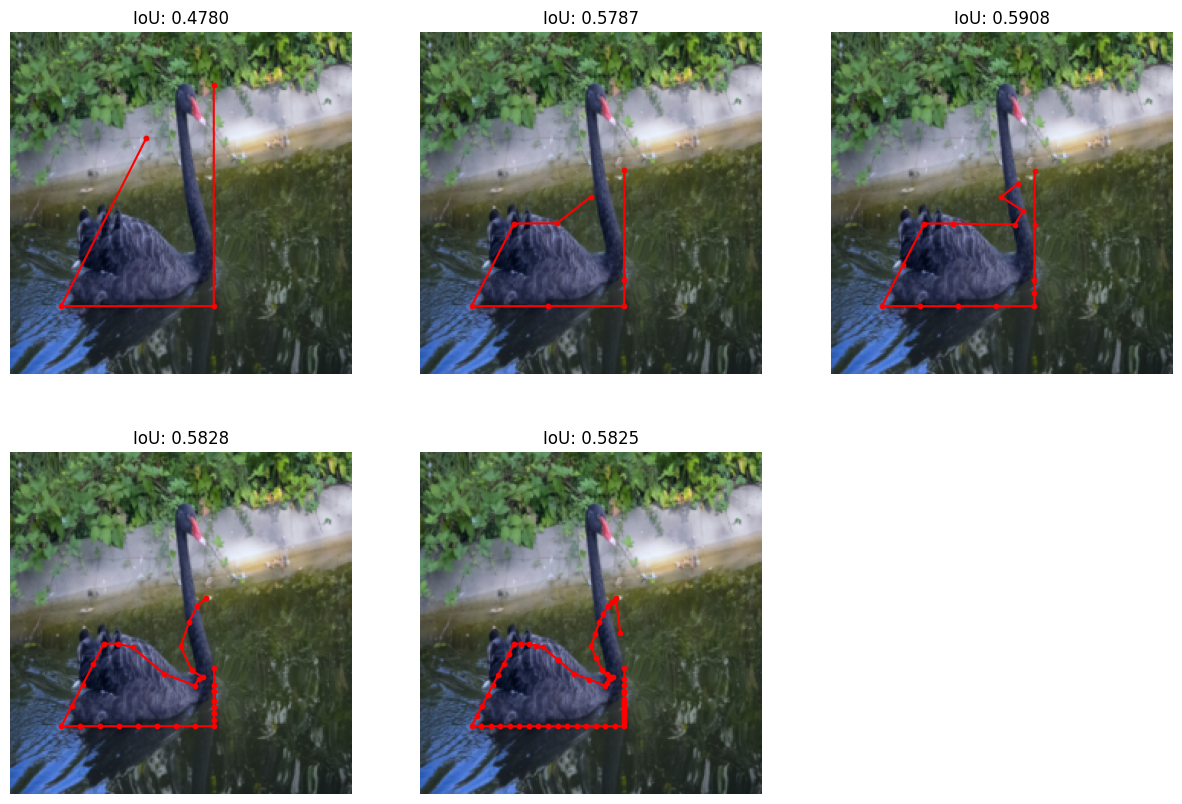

In [205]:
def overfit_one_imge(img: torch.Tensor, mask: torch.Tensor):
    batch_img = img.unsqueeze(0).cuda()
    batch_mask = mask.unsqueeze(0).cuda()
    model = ImageIterBase(layer_num=1).cuda()
    ras_loss = RasLoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_dict = {}
    iou_dict = {}
    for e in range(epoch_num):
        model.train()
        optimizer.zero_grad()
        pred_boundary = model(batch_img, batch_mask)
        loss = 0
        for i in range(len(pred_boundary)):
            loss += ras_loss(pred_boundary[i], batch_mask)
        loss /= len(pred_boundary)
        loss.backward()
        optimizer.step()
        loss_dict[e] = loss.item()
        iou = get_bou_iou(0, pred_boundary[-1], batch_mask, ras_loss.soft_polygon)
        iou_dict[e] = iou.item()
        print(f"Epoch {e}, Loss: {loss.item()}, IoU: {iou.item()}")
    pred_boundary = model(batch_img, batch_mask)
    show_one_image_result(batch_img, batch_mask, pred_boundary, ras_loss.soft_polygon)
    return loss_dict, iou_dict
loss_dict, iou_dict = overfit_one_imge(swan_img, swan_mask)



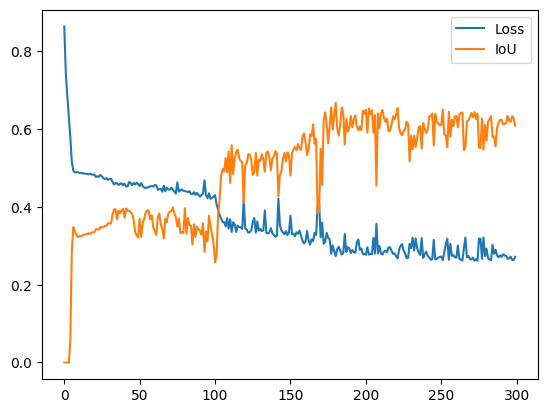

In [206]:
# show iou and loss
plt.figure()
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


EPOCH 0, Dif Loss: 0.8513, Len Loss: 0.1998, Std Loss: 0.0446, IoU: 0.0000
EPOCH 1, Dif Loss: 0.6488, Len Loss: 0.1973, Std Loss: 0.0380, IoU: 0.0524
EPOCH 2, Dif Loss: 0.5274, Len Loss: 0.2038, Std Loss: 0.0373, IoU: 0.2554
EPOCH 3, Dif Loss: 0.5016, Len Loss: 0.2029, Std Loss: 0.0329, IoU: 0.3349
EPOCH 4, Dif Loss: 0.5080, Len Loss: 0.2069, Std Loss: 0.0369, IoU: 0.3409
EPOCH 5, Dif Loss: 0.4942, Len Loss: 0.2042, Std Loss: 0.0402, IoU: 0.3606
EPOCH 6, Dif Loss: 0.4839, Len Loss: 0.1970, Std Loss: 0.0366, IoU: 0.3490
EPOCH 7, Dif Loss: 0.5060, Len Loss: 0.1865, Std Loss: 0.0315, IoU: 0.2794
EPOCH 8, Dif Loss: 0.4733, Len Loss: 0.1933, Std Loss: 0.0332, IoU: 0.3629
EPOCH 9, Dif Loss: 0.4811, Len Loss: 0.1948, Std Loss: 0.0267, IoU: 0.3613
EPOCH 10, Dif Loss: 0.4652, Len Loss: 0.1894, Std Loss: 0.0218, IoU: 0.3705
EPOCH 11, Dif Loss: 0.4737, Len Loss: 0.1950, Std Loss: 0.0299, IoU: 0.3690
EPOCH 12, Dif Loss: 0.4693, Len Loss: 0.1882, Std Loss: 0.0302, IoU: 0.3587
EPOCH 13, Dif Loss: 0.

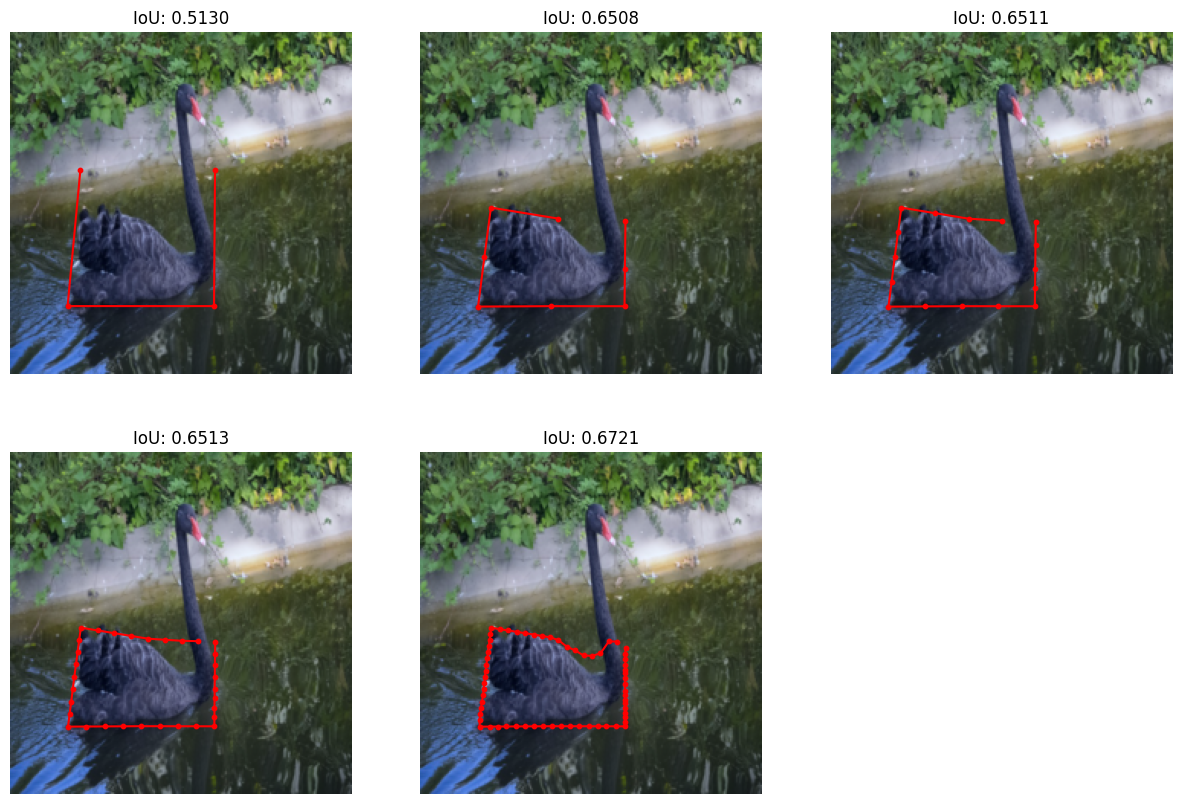

In [207]:
def overfitting_one_image_with_more_losses(img: torch.Tensor, mask: torch.Tensor):
    batch_img = img.unsqueeze(0).cuda()
    batch_mask = mask.unsqueeze(0).cuda()
    model = ImageIterBase(layer_num=1).cuda()
    ras_loss = RasLoss().cuda()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    dif_loss_dict = {}
    len_loss_dict = {}
    std_loss_dict = {}
    iou_dict = {}
    for e in range(epoch_num):
        model.train()
        optimizer.zero_grad()
        pred_boundary = model(batch_img, batch_mask)
        dif_loss = 0
        len_loss = 0
        std_loss = 0
        for i in range(len(pred_boundary)):
            dif_loss += ras_loss(pred_boundary[i], batch_mask)
            len_loss += total_len_loss(pred_boundary[i])
            tmp_std_loss = deviation_loss(pred_boundary[i])
            if tmp_std_loss > 0.001:
                std_loss += tmp_std_loss
            else:
                std_loss += 0
        dif_loss /= len(pred_boundary)
        len_loss /= len(pred_boundary)
        std_loss /= len(pred_boundary)
        loss = dif_weight * dif_loss + len_weight * len_loss + std_weight * std_loss
        loss.backward()
        optimizer.step()
        iou = get_bou_iou(0, pred_boundary[-1], batch_mask, ras_loss.soft_polygon)
        iou_dict[e] = iou.item()
        dif_loss_dict[e] = dif_loss.item()
        len_loss_dict[e] = len_loss.item()
        std_loss_dict[e] = std_loss.item() if std_loss != 0 else 0
        print(f"EPOCH {e}, Dif Loss: {dif_loss.item():.4f}, Len Loss: {len_loss.item():.4f}, Std Loss: {std_loss_dict[e]:.4f}, IoU: {iou.item():.4f}")
    pred_boundary = model(batch_img, batch_mask)
    show_one_image_result(batch_img, batch_mask, pred_boundary, ras_loss.soft_polygon)
    return dif_loss_dict, len_loss_dict, std_loss_dict, iou_dict
dif_loss_dict, len_loss_dict, std_loss_dict, iou_dict = overfitting_one_image_with_more_losses(swan_img, swan_mask)

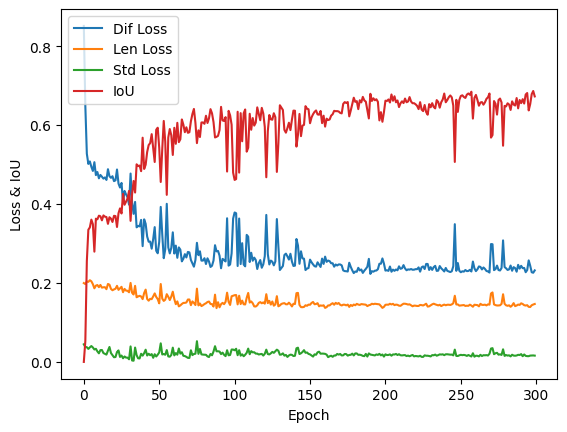

In [208]:
# show iou and loss
plt.figure()
plt.plot(list(dif_loss_dict.keys()), list(dif_loss_dict.values()), label="Dif Loss")
plt.plot(list(len_loss_dict.keys()), list(len_loss_dict.values()), label="Len Loss")
plt.plot(list(std_loss_dict.keys()), list(std_loss_dict.values()), label="Std Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/work3/s232248/miniconda3/envs/rass/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0, Loss: 0.891091525554657, IoU: 0.0
Epoch 1, Loss: 0.8241277933120728, IoU: 0.0
Epoch 2, Loss: 0.72112637758255, IoU: 0.0
Epoch 3, Loss: 0.609607458114624, IoU: 0.026202592998743057
Epoch 4, Loss: 0.5151634216308594, IoU: 0.1446419507265091
Epoch 5, Loss: 0.4489052891731262, IoU: 0.24148055911064148
Epoch 6, Loss: 0.3943140208721161, IoU: 0.3662821054458618
Epoch 7, Loss: 0.37746119499206543, IoU: 0.43552592396736145
Epoch 8, Loss: 0.37202566862106323, IoU: 0.451979398727417
Epoch 9, Loss: 0.3705686032772064, IoU: 0.45628833770751953
Epoch 10, Loss: 0.3699779510498047, IoU: 0.458196222782135
Epoch 11, Loss: 0.36961331963539124, IoU: 0.4592606723308563
Epoch 12, Loss: 0.36882802844047546, IoU: 0.46048852801322937
Epoch 13, Loss: 0.3687654435634613, IoU: 0.46066147089004517
Epoch 14, Loss: 0.3692631423473358, IoU: 0.4602728486061096
Epoch 15, Loss: 0.36888739466667175, IoU: 0.4608195126056671
Epoch 16, Loss: 0.3682793080806732, IoU: 0.46186015009880066
Epoch 17, Loss: 0.3685742020

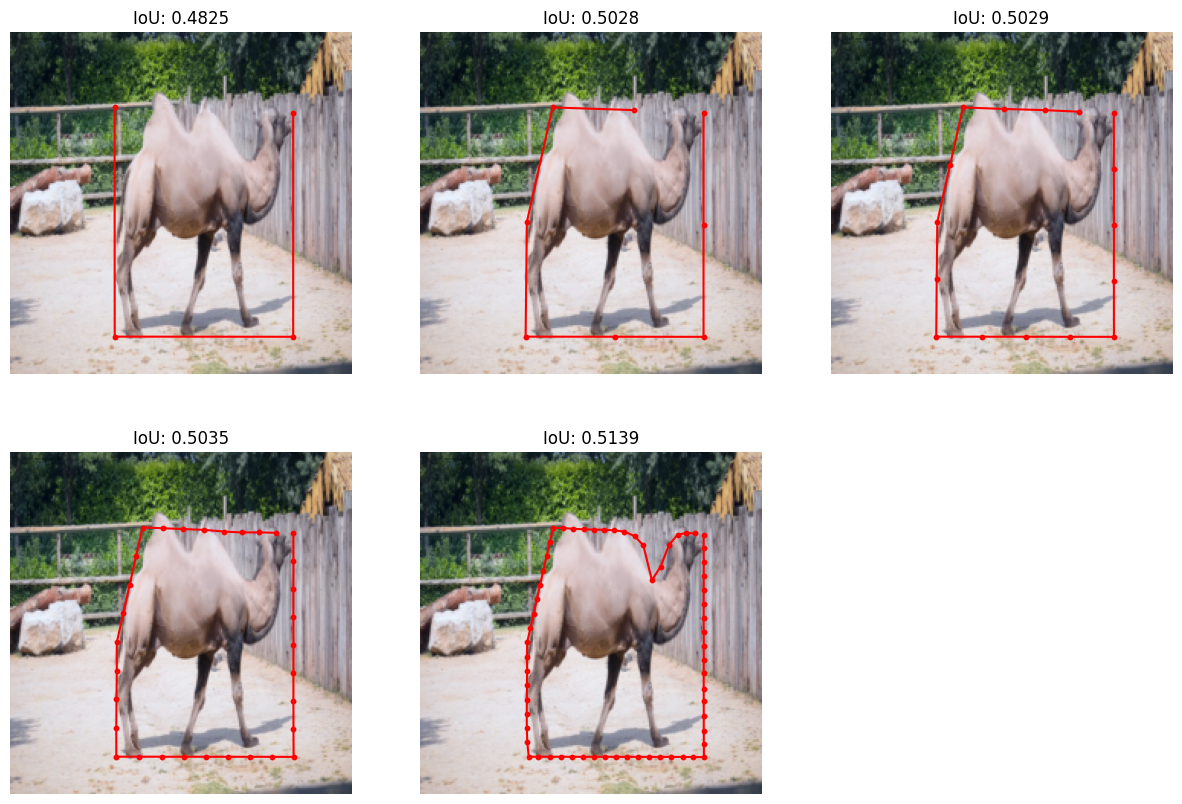

In [214]:
# overfitting camel image
loss_dict, iou_dict = overfit_one_imge(camel_img, camel_mask)

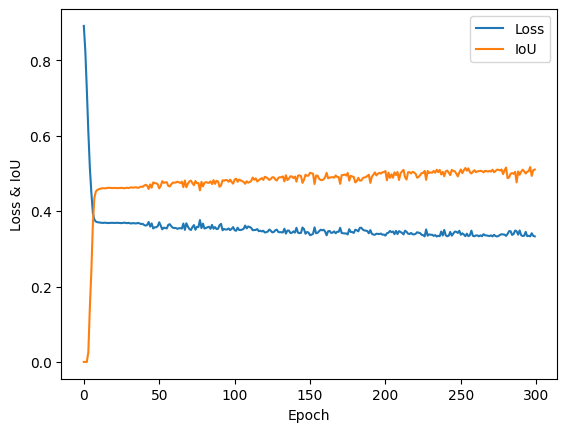

In [215]:
# show iou and loss
plt.figure()
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


EPOCH 0, Dif Loss: 0.9007, Len Loss: 0.1863, Std Loss: 0.0516, IoU: 0.0000
EPOCH 1, Dif Loss: 0.8233, Len Loss: 0.2137, Std Loss: 0.0551, IoU: 0.0000
EPOCH 2, Dif Loss: 0.7486, Len Loss: 0.2232, Std Loss: 0.0511, IoU: 0.0032
EPOCH 3, Dif Loss: 0.6503, Len Loss: 0.2321, Std Loss: 0.0453, IoU: 0.0184
EPOCH 4, Dif Loss: 0.5463, Len Loss: 0.2355, Std Loss: 0.0423, IoU: 0.0877
EPOCH 5, Dif Loss: 0.4787, Len Loss: 0.2378, Std Loss: 0.0379, IoU: 0.1947
EPOCH 6, Dif Loss: 0.4340, Len Loss: 0.2391, Std Loss: 0.0376, IoU: 0.2727
EPOCH 7, Dif Loss: 0.4025, Len Loss: 0.2391, Std Loss: 0.0370, IoU: 0.3504
EPOCH 8, Dif Loss: 0.3827, Len Loss: 0.2388, Std Loss: 0.0367, IoU: 0.4076
EPOCH 9, Dif Loss: 0.3743, Len Loss: 0.2385, Std Loss: 0.0364, IoU: 0.4397
EPOCH 10, Dif Loss: 0.3718, Len Loss: 0.2386, Std Loss: 0.0363, IoU: 0.4505
EPOCH 11, Dif Loss: 0.3702, Len Loss: 0.2385, Std Loss: 0.0363, IoU: 0.4557
EPOCH 12, Dif Loss: 0.3693, Len Loss: 0.2386, Std Loss: 0.0363, IoU: 0.4593
EPOCH 13, Dif Loss: 0.

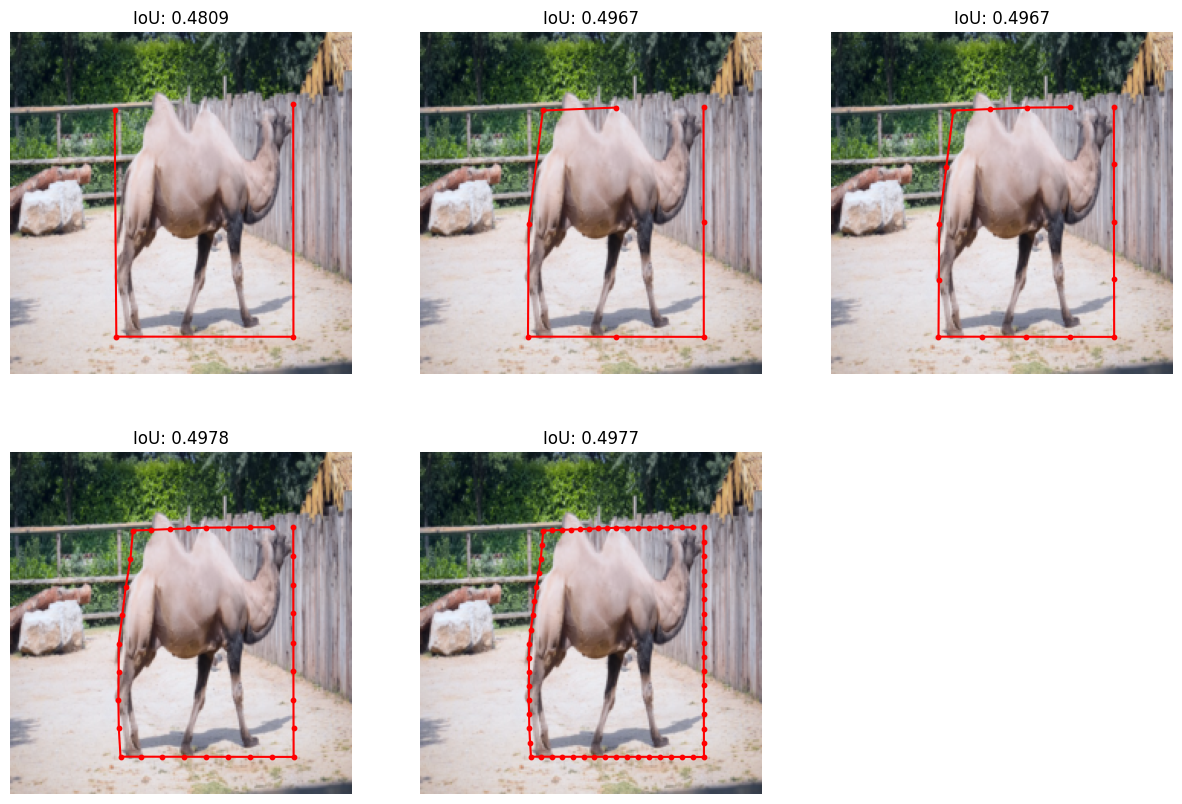

In [216]:
dif_loss_dict, len_loss_dict, std_loss_dict, iou_dict = overfitting_one_image_with_more_losses(camel_img, camel_mask)

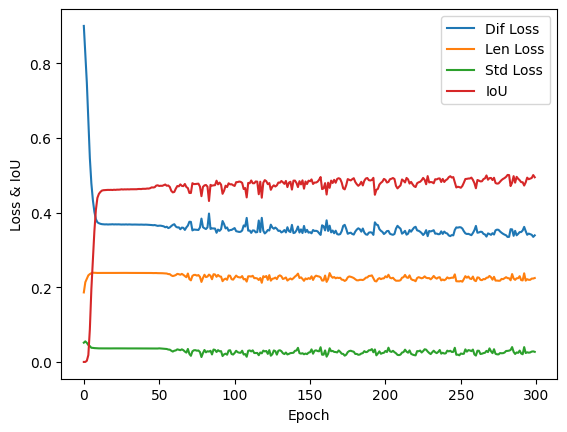

In [217]:
# show iou and loss
plt.figure()
plt.plot(list(dif_loss_dict.keys()), list(dif_loss_dict.values()), label="Dif Loss")
plt.plot(list(len_loss_dict.keys()), list(len_loss_dict.values()), label="Len Loss")
plt.plot(list(std_loss_dict.keys()), list(std_loss_dict.values()), label="Std Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


Epoch 0, Loss: 0.8775367736816406, IoU: 0.0
Epoch 1, Loss: 0.7386264801025391, IoU: 2.139373464160599e-06
Epoch 2, Loss: 0.561837375164032, IoU: 0.07357938587665558
Epoch 3, Loss: 0.44457218050956726, IoU: 0.1967259794473648
Epoch 4, Loss: 0.3679415285587311, IoU: 0.34192436933517456
Epoch 5, Loss: 0.3277769088745117, IoU: 0.44512781500816345
Epoch 6, Loss: 0.30984288454055786, IoU: 0.5017908215522766
Epoch 7, Loss: 0.302788645029068, IoU: 0.522905707359314
Epoch 8, Loss: 0.2991142272949219, IoU: 0.5333356261253357
Epoch 9, Loss: 0.2979261577129364, IoU: 0.536970317363739
Epoch 10, Loss: 0.29702016711235046, IoU: 0.5394552946090698
Epoch 11, Loss: 0.2967540919780731, IoU: 0.5407570004463196
Epoch 12, Loss: 0.2962091267108917, IoU: 0.5416725277900696
Epoch 13, Loss: 0.2963198721408844, IoU: 0.541924238204956
Epoch 14, Loss: 0.2960844933986664, IoU: 0.5422300100326538
Epoch 15, Loss: 0.29605039954185486, IoU: 0.5425437092781067
Epoch 16, Loss: 0.2957276701927185, IoU: 0.5427646636962891


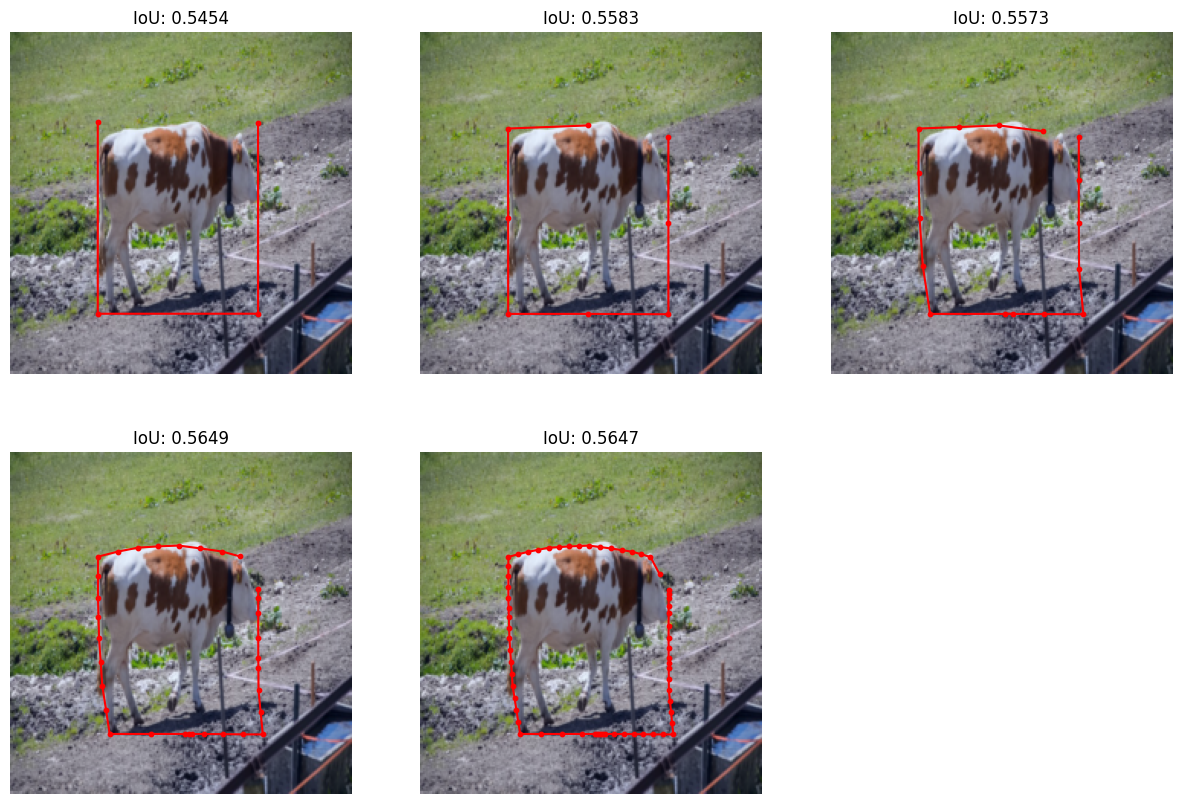

In [218]:
# overfitting cow image
loss_dict, iou_dict = overfit_one_imge(cow_img, cow_mask)

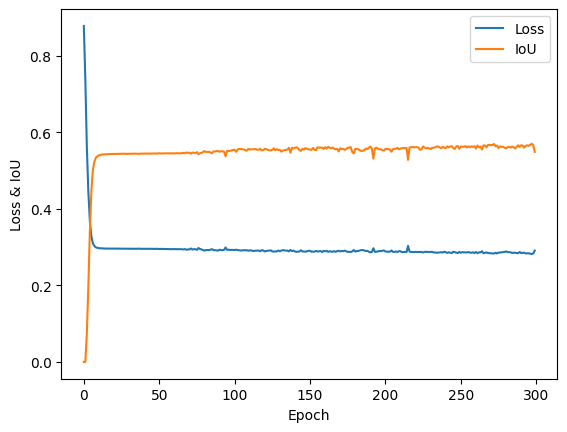

In [220]:
# show iou and loss
plt.figure()
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()


Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


EPOCH 0, Dif Loss: 0.8550, Len Loss: 0.1915, Std Loss: 0.0284, IoU: 0.0002
EPOCH 1, Dif Loss: 0.6846, Len Loss: 0.1993, Std Loss: 0.0200, IoU: 0.0263
EPOCH 2, Dif Loss: 0.4989, Len Loss: 0.1996, Std Loss: 0.0196, IoU: 0.1758
EPOCH 3, Dif Loss: 0.3964, Len Loss: 0.1977, Std Loss: 0.0186, IoU: 0.3277
EPOCH 4, Dif Loss: 0.3366, Len Loss: 0.1991, Std Loss: 0.0182, IoU: 0.4420
EPOCH 5, Dif Loss: 0.3131, Len Loss: 0.1997, Std Loss: 0.0179, IoU: 0.4986
EPOCH 6, Dif Loss: 0.3049, Len Loss: 0.1998, Std Loss: 0.0180, IoU: 0.5192
EPOCH 7, Dif Loss: 0.2999, Len Loss: 0.1995, Std Loss: 0.0180, IoU: 0.5311
EPOCH 8, Dif Loss: 0.2986, Len Loss: 0.1997, Std Loss: 0.0181, IoU: 0.5356
EPOCH 9, Dif Loss: 0.2972, Len Loss: 0.1996, Std Loss: 0.0179, IoU: 0.5378
EPOCH 10, Dif Loss: 0.2967, Len Loss: 0.1996, Std Loss: 0.0180, IoU: 0.5398
EPOCH 11, Dif Loss: 0.2958, Len Loss: 0.1995, Std Loss: 0.0179, IoU: 0.5421
EPOCH 12, Dif Loss: 0.2960, Len Loss: 0.1997, Std Loss: 0.0181, IoU: 0.5423
EPOCH 13, Dif Loss: 0.

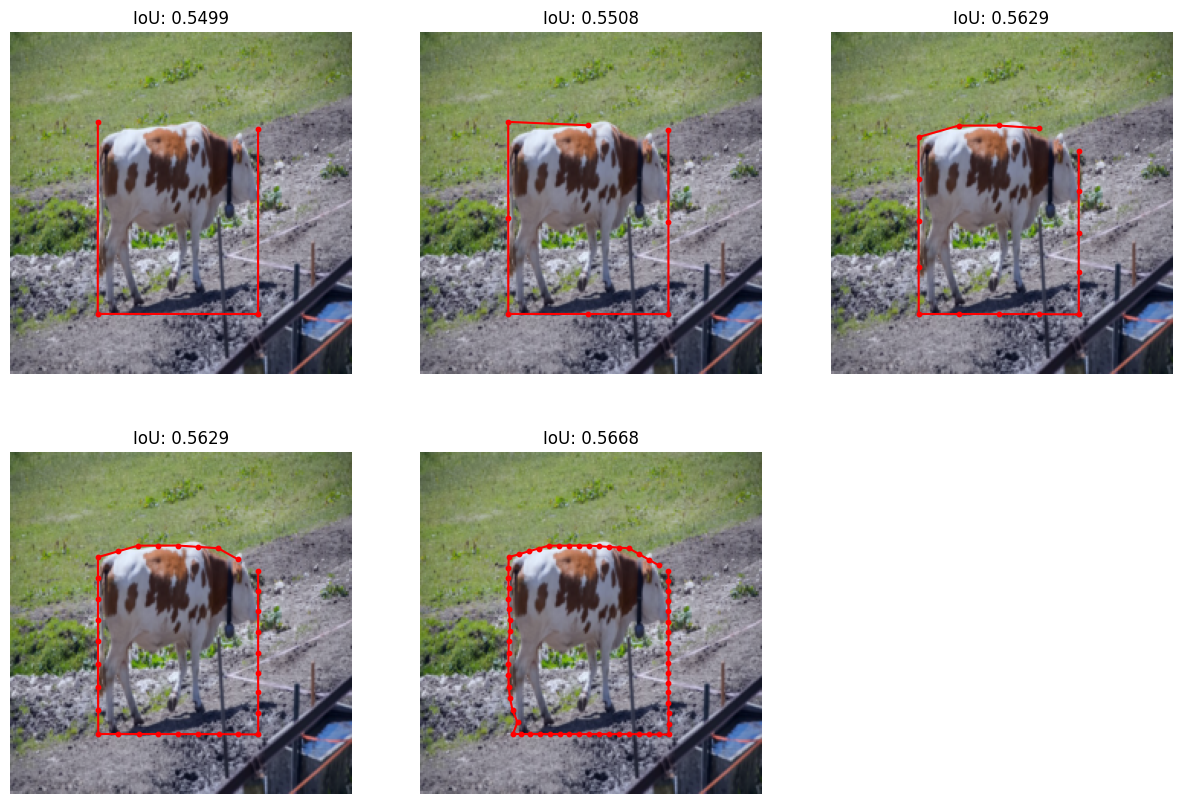

In [221]:
dif_loss_dict, len_loss_dict, std_loss_dict, iou_dict = overfitting_one_image_with_more_losses(cow_img, cow_mask)

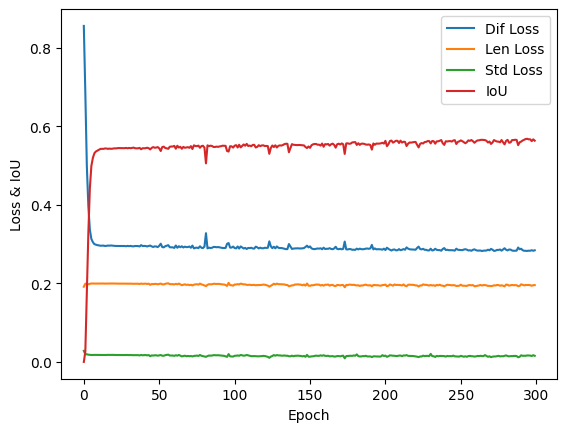

In [222]:
# show iou and loss
plt.figure()
plt.plot(list(dif_loss_dict.keys()), list(dif_loss_dict.values()), label="Dif Loss")
plt.plot(list(len_loss_dict.keys()), list(len_loss_dict.values()), label="Len Loss")
plt.plot(list(std_loss_dict.keys()), list(std_loss_dict.values()), label="Std Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()


Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


Epoch 0, Loss: 0.7396270632743835, IoU: 0.005106727592647076
Epoch 1, Loss: 0.556330680847168, IoU: 0.15447469055652618
Epoch 2, Loss: 0.43167978525161743, IoU: 0.36382976174354553
Epoch 3, Loss: 0.41047874093055725, IoU: 0.4007704555988312
Epoch 4, Loss: 0.4029441773891449, IoU: 0.4178392291069031
Epoch 5, Loss: 0.4037955701351166, IoU: 0.42130082845687866
Epoch 6, Loss: 0.39759185910224915, IoU: 0.43137839436531067
Epoch 7, Loss: 0.396137535572052, IoU: 0.43477293848991394
Epoch 8, Loss: 0.3962832987308502, IoU: 0.4345702528953552
Epoch 9, Loss: 0.3918773829936981, IoU: 0.43875738978385925
Epoch 10, Loss: 0.3964298665523529, IoU: 0.43576303124427795
Epoch 11, Loss: 0.3993256390094757, IoU: 0.4335278272628784
Epoch 12, Loss: 0.38694679737091064, IoU: 0.44830521941185
Epoch 13, Loss: 0.3851000964641571, IoU: 0.4496895372867584
Epoch 14, Loss: 0.3837924599647522, IoU: 0.45322364568710327
Epoch 15, Loss: 0.38470137119293213, IoU: 0.4535132050514221
Epoch 16, Loss: 0.379412978887558, IoU:

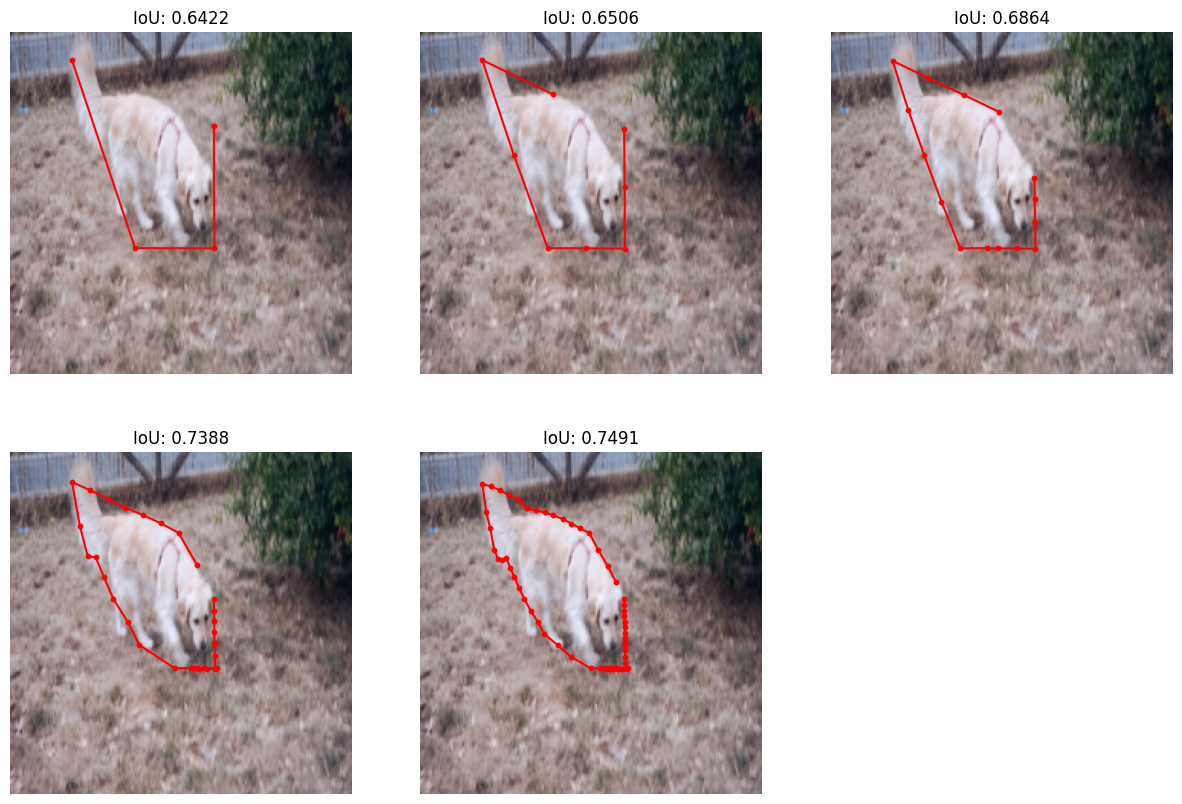

In [223]:
# overfitting dog image
loss_dict, iou_dict = overfit_one_imge(dog_img, dog_mask)

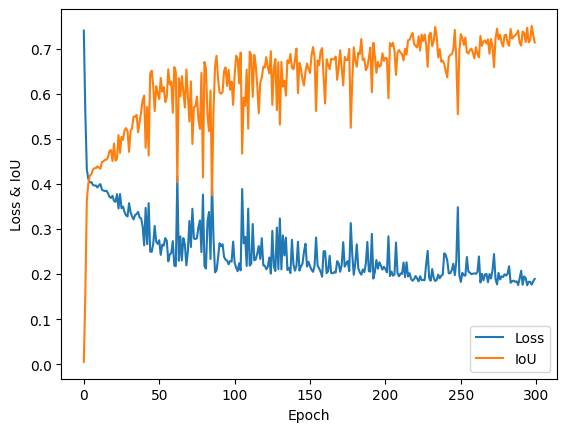

In [224]:
# show iou and loss
plt.figure()
plt.plot(list(loss_dict.keys()), list(loss_dict.values()), label="Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()


Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


EPOCH 0, Dif Loss: 0.8261, Len Loss: 0.1898, Std Loss: 0.0367, IoU: 0.0000
EPOCH 1, Dif Loss: 0.6815, Len Loss: 0.1951, Std Loss: 0.0396, IoU: 0.0416
EPOCH 2, Dif Loss: 0.5234, Len Loss: 0.1950, Std Loss: 0.0366, IoU: 0.1983
EPOCH 3, Dif Loss: 0.4214, Len Loss: 0.1900, Std Loss: 0.0299, IoU: 0.3782
EPOCH 4, Dif Loss: 0.4166, Len Loss: 0.1942, Std Loss: 0.0349, IoU: 0.3972
EPOCH 5, Dif Loss: 0.3977, Len Loss: 0.1911, Std Loss: 0.0314, IoU: 0.4276
EPOCH 6, Dif Loss: 0.3969, Len Loss: 0.1888, Std Loss: 0.0286, IoU: 0.4323
EPOCH 7, Dif Loss: 0.3781, Len Loss: 0.1857, Std Loss: 0.0251, IoU: 0.4530
EPOCH 8, Dif Loss: 0.3923, Len Loss: 0.1867, Std Loss: 0.0271, IoU: 0.4382
EPOCH 9, Dif Loss: 0.3912, Len Loss: 0.1866, Std Loss: 0.0279, IoU: 0.4426
EPOCH 10, Dif Loss: 0.3864, Len Loss: 0.1825, Std Loss: 0.0243, IoU: 0.4456
EPOCH 11, Dif Loss: 0.3811, Len Loss: 0.1692, Std Loss: 0.0091, IoU: 0.4255
EPOCH 12, Dif Loss: 0.3849, Len Loss: 0.1705, Std Loss: 0.0112, IoU: 0.4309
EPOCH 13, Dif Loss: 0.

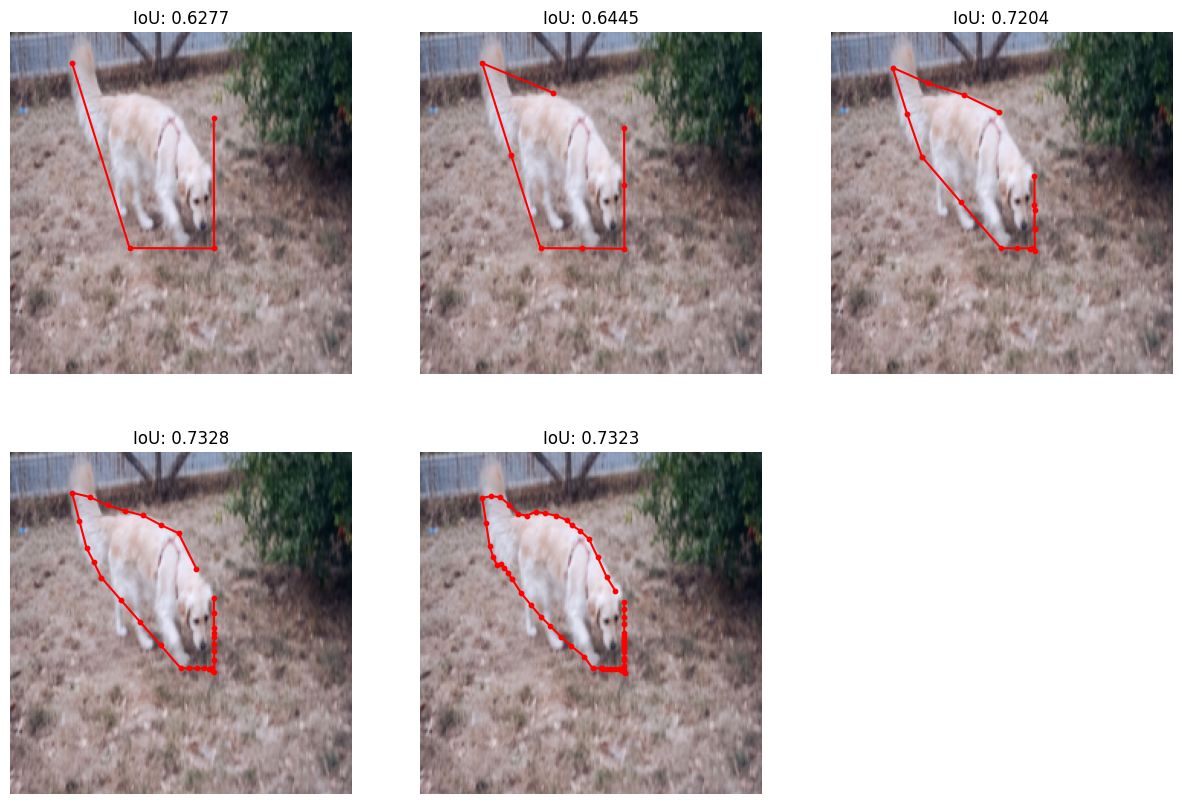

In [225]:
# overfitting dog image with more losses
dif_loss_dict, len_loss_dict, std_loss_dict, iou_dict = overfitting_one_image_with_more_losses(dog_img, dog_mask)

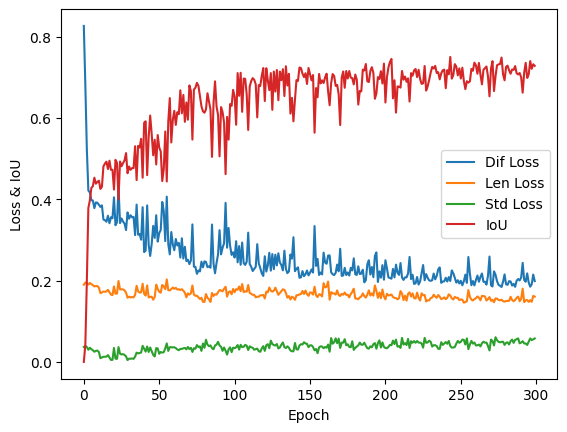

In [226]:
# show iou and loss
plt.figure()
plt.plot(list(dif_loss_dict.keys()), list(dif_loss_dict.values()), label="Dif Loss")
plt.plot(list(len_loss_dict.keys()), list(len_loss_dict.values()), label="Len Loss")
plt.plot(list(std_loss_dict.keys()), list(std_loss_dict.values()), label="Std Loss")
plt.plot(list(iou_dict.keys()), list(iou_dict.values()), label="IoU")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss & IoU")
plt.show()
